大模型（LLM）通常都是以问答的形式给出的，这种模型通常会给出一个问题和一个答案。但是大家都知道大模型存在一个问题：幻觉。由于大模型是基于提问的prompt来进行token预测的，它在缺少可靠的数据时，也会给出一个看似合理的回答，那么我们该怎么解决这个问题呢？RAG（检索增强生成）可以比较好的解决这个问题。

# 什么是RAG？
RAG（Retrieval Augmented Generation）是一种用于文本生成任务的方法，它通过引入外部知识库（Knowledge Base，KB）来增强模型的生成能力。在RAG中，模型首先根据输入的文本信息从KB中检索出相关的信息，然后根据检索到的信息生成相应的文本。

在RAG中，模型分为两个阶段：

a. Retrieval：根据输入的文本信息从KB中检索出相关的信息。
b. Generation：根据检索到的信息生成相应的文本。

## RAG的工作原理
RAG 为解决大模型幻觉提供了一种新的思路，它通过引入外部知识库来增强模型的生成能力，从而提高了模型的生成质量。下面是一个简单的RAG的工作原理：

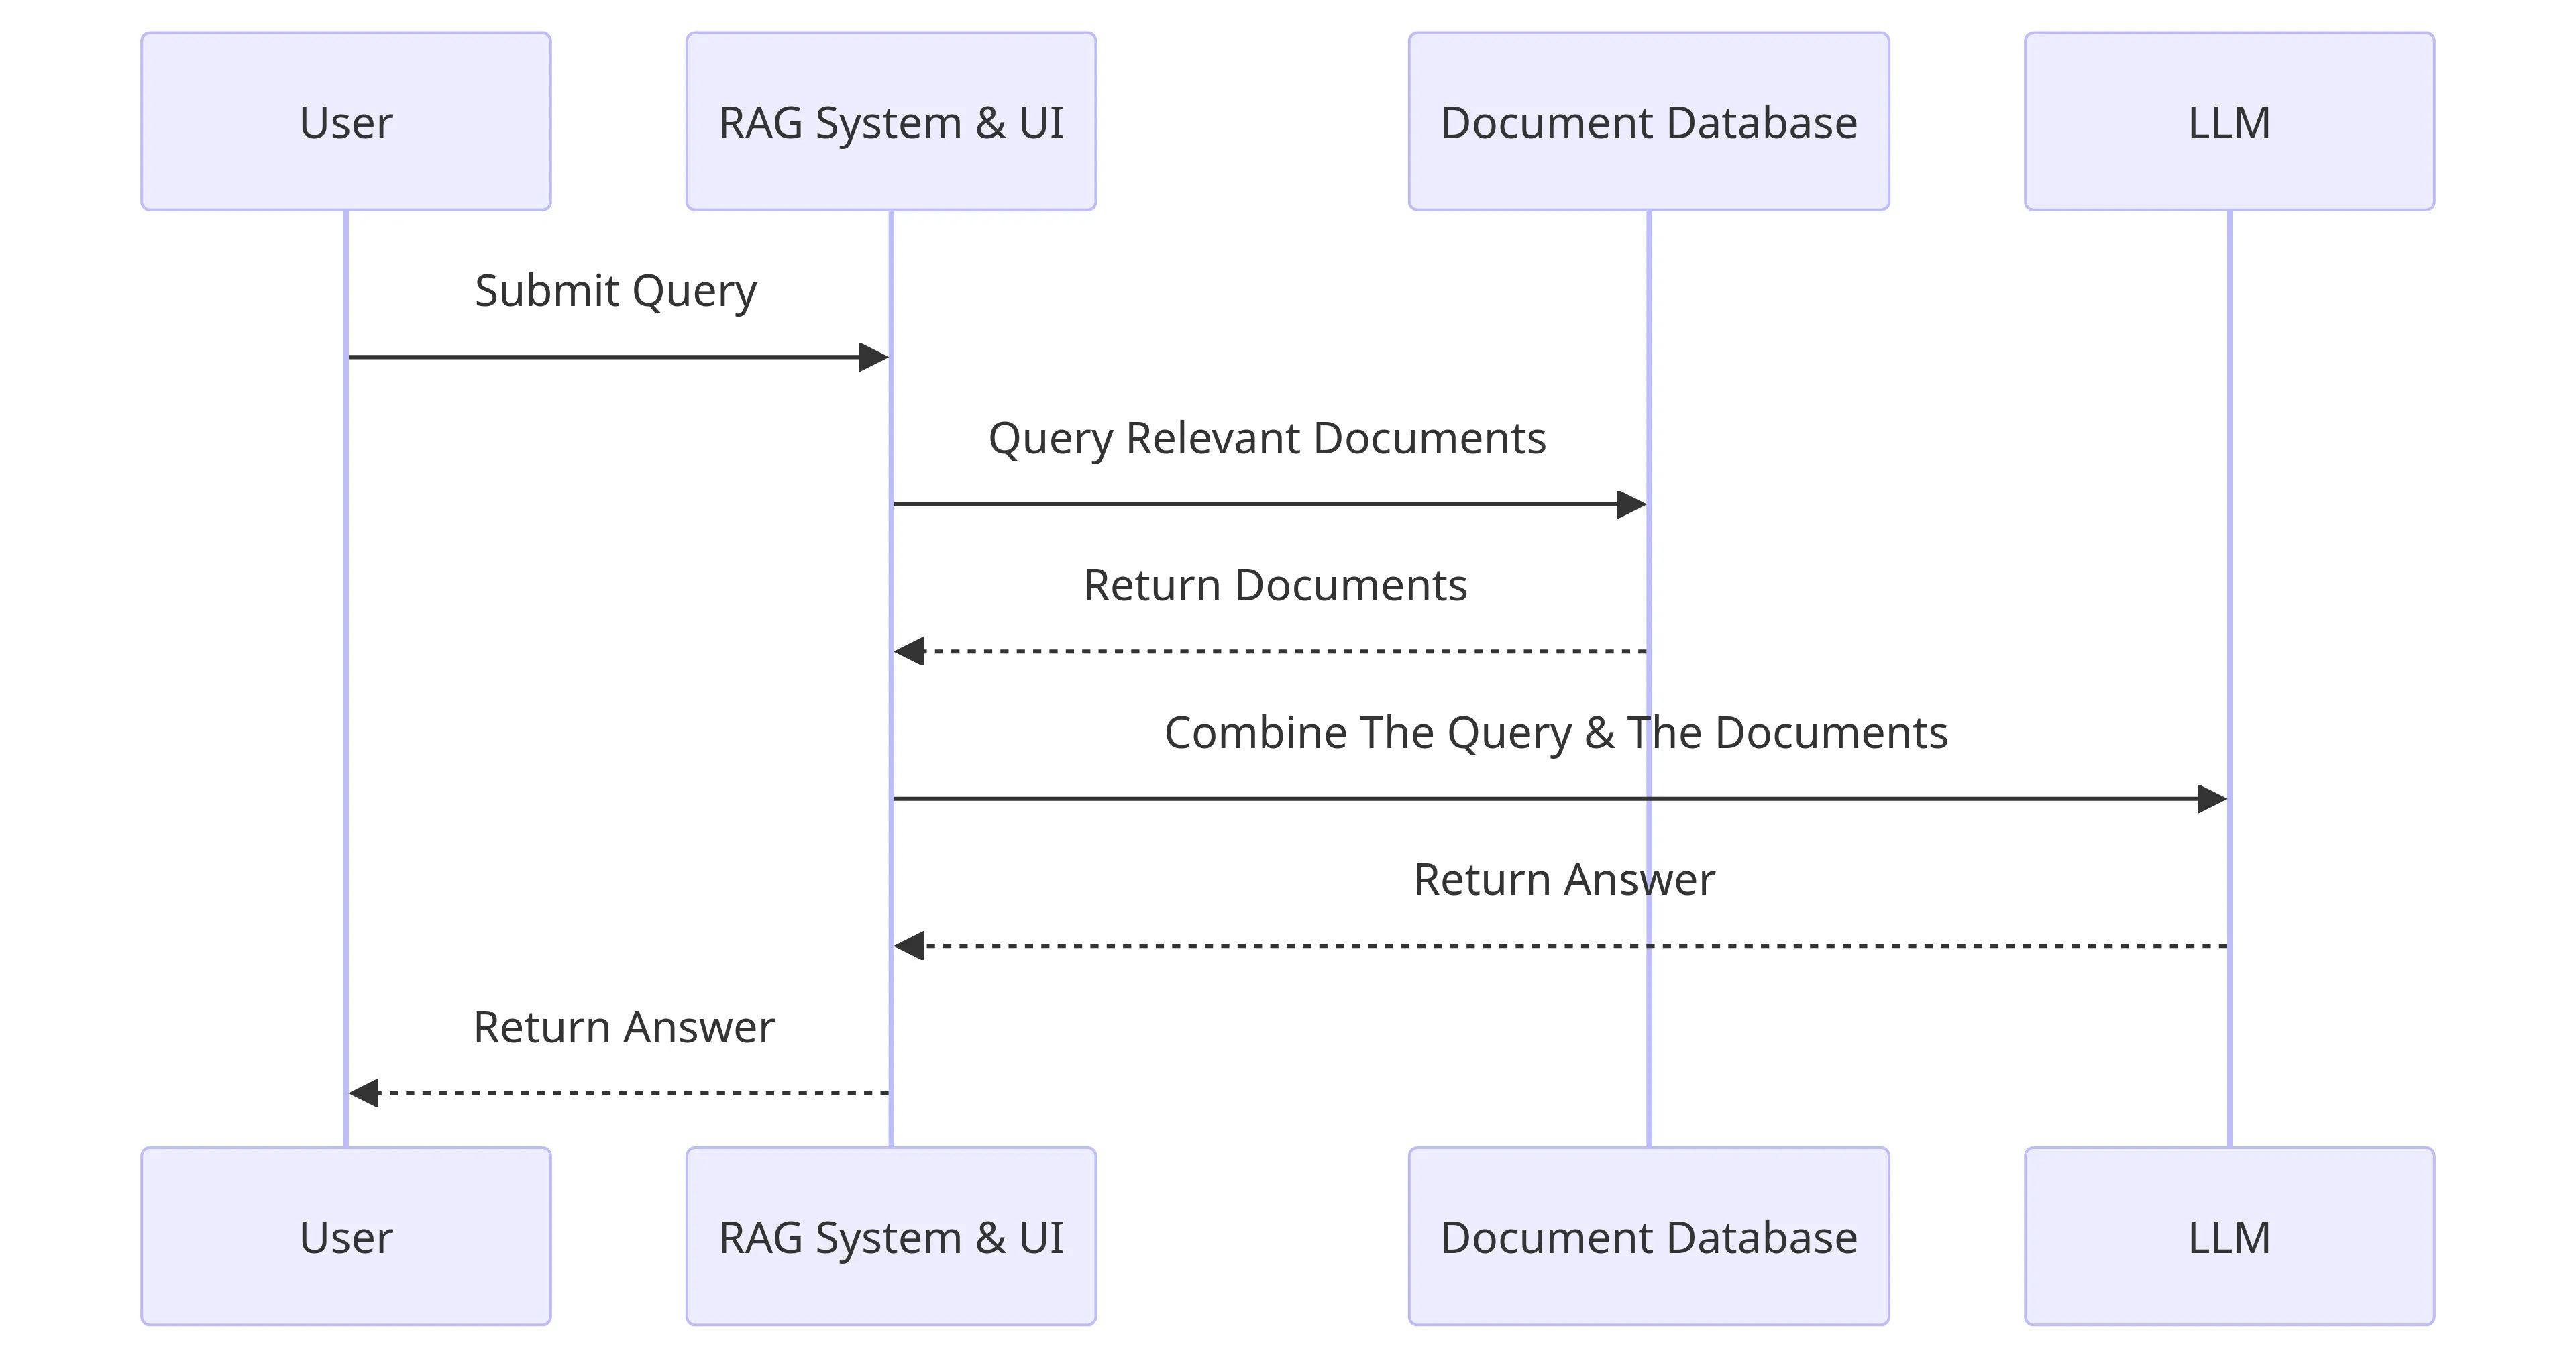

1. 用户(user)输入一个问题提交到RAG系统(RAG System)。
2. RAG系统通过用户输入的问题查询知识库(Document Database)。
3. 知识库接收请求，返回相关的文档给RAG系统。
4. RAG系统组合用户提问和知识库返回的文档，生成一个新的prompt。
5. RAG系统将新的prompt输入到大模型中，生成一个回答。
6. RAG系统将大模型生成的回答返回给用户。

## 查询相关文档
查询相关文档是RAG的非常重要的一步，如何创建知识库呢？这里有两种方法：
1. 使用传统的关键词检索方法，例如使用elasticsearch做知识库存储，然后通过elasticsearch的检索功能来检索相关的文档。
2. 使用Embedding方法，先将文档分块，然后将文档块转换为向量，再通过向量的相似度来检索相关的文档块。

我们主要介绍第二种方法，即使用Embedding方法，如下图所示：

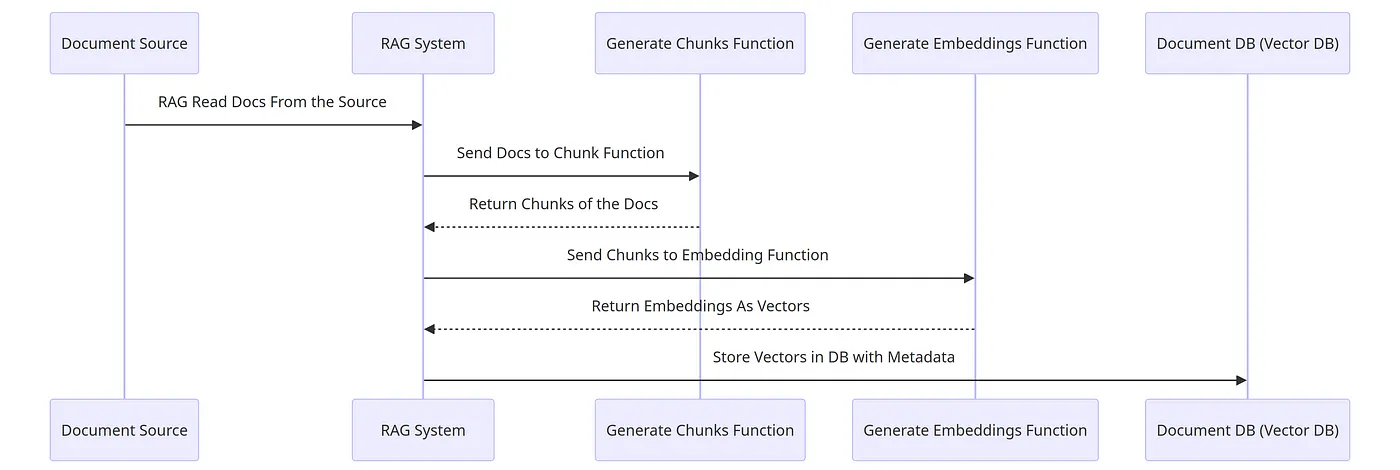

1. 读取文档，可以网页、markdown、doc、pdf等各种类型的文档；
2. 将文档分块，可以按照段落、句子、词等不同的粒度进行分块；
3. 将文档块转换为向量，可以使用openai的embeddings模型，或者部署开源的embeddings模型来转换文档块为向量；
4. 将向量存储到知识库中，可以使用elasticsearch、faiss等工具来存储向量。

## 检索相关文档
正如我们第一个图所示，当用户提交一个问题到RAG系统时，RAG系统会首先查询向量知识库，然后将查询到的文档返回给RAG系统。这个过程如下图所示：
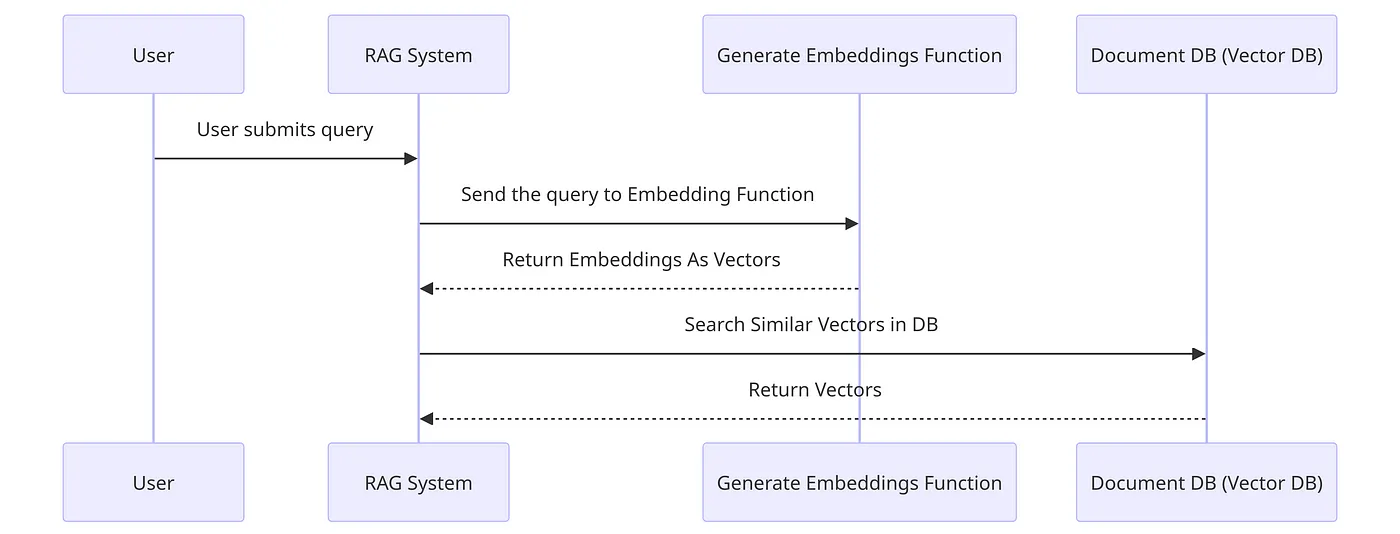

1. 用户提交问题到RAG系统；
2. RAG系统将问题转换为向量；
3. RAG系统查询向量知识库，将问题向量与向量库中的文档向量进行相似度计算；
4. 向量知识库返回相似度最高的top K文档给RAG系统。

## 组合用户提问和知识库返回的文档
一旦RAG系统查询到相关的文档，它会将用户提问和文档组合成一个新的prompt，然后将这个prompt输入到大模型中，生成一个回答。下面是一个简单的示例：
```python
ANSWER_TEMPLATE = """你是问答助手，基于[上下文]和[问题]，
为用户提供了一份最佳的回答，回答要求是你经过深思熟虑、符合业务逻辑和全面详细的。“

[上下文]'''
{context}
'''

[问题]'''
{question}
'''
"""
```

# 具体实现
上面我们介绍了RAG的工作原理，下面我们通过一个具体的例子来实现RAG系统。我们使用一个简单的知识库，知识库中包含了一些文档，我们首先将文档分块，然后将文档块转换为向量，最后将向量存储到elasticsearch中。然后我们使用RAG系统来查询知识库，生成回答。

## 知识库建立
首先，我们使用elasticsearch（Elasticsearch 从7.3 版本开始支持向量搜索）来存储向量，elasticsearch是一个分布式的搜索引擎，它也支持向量的存储和检索。
其次，我使用的是腾讯云，我将使用腾讯云混元作为大模型，使用混元大模型的embedding模型来将文本转换为向量, 下面我们手把手搭建一个RAG系统。

### 安装依赖包
我使用的是腾讯云的混元大模型和langchain的langserve来搭建系统。首先，我们需要安装相关依赖包：
```bash
pip install "langserve[all]"
pip install langchain
pip install pydantic_settings
pip install tencentcloud-sdk-python
pip install tqdm
pip install langchain_elasticsearch
pip install langchain_community
```

### 创建知识库
首先需要再腾讯云上购买elasticsearch数据库和开通腾讯云混元服务。elasticsearch建议购买8.x以上，下面创建向量知识库的过程：

In [ ]:
import config
from hunyuan import HunyuanEmbeddings
from langchain_elasticsearch import ElasticsearchStore
from typing import List
from langchain_core.documents import Document

## 1. 混元embedding 初始化
secretid = config.get_settings().tcloud_secret_id
secretkey = config.get_settings().tcloud_secret_key
## 1.1 注意这里HunyuanEmbeddings在我附件提供的github仓库中，需要自行下载
embeddings = HunyuanEmbeddings(
    secret_id=secretid,
    secret_key=secretkey,
    embedding_ctx_length=786,
)

## 2. 初始化elasticsearch store
ES_URL = config.get_settings().es_url
ES_API_KEY = config.get_settings().es_api_key

elastic_vector_search = ElasticsearchStore(
    embedding=embeddings,
    index_name="langchain_index",
    es_url=ES_URL,
    es_api_key=ES_API_KEY,
)

documents: List[Document] = []
text = '''
# 2024年巴黎奥运会的金牌情况

## 1. 2024巴黎奥运会概况：
   - **赛事时间与项目数量**：2024年巴黎奥运会于当地时间8月11日结束，历时16天，共设有329个奖牌项目。
   - **金牌榜前十名国家**：美国以126枚奖牌（40金、44银、42铜）位居榜首；中国紧随其后，获得91枚奖牌（40金、27银、24铜）；日本、澳大利亚、法国分别位列第三至第五名。
   - **中国代表团总体表现**：中国代表团在本次奥运会上表现出色，获得40枚金牌，总奖牌数达到91枚，位居第二。

## 2. 中国代表团详细表现：
   - **首金获得者及项目**：射击混合团体10米气步枪冠军，由来自江苏的盛李豪和来自浙江的黄雨婷夺得。
   - **前十枚金牌项目及获得者**：包括跳水女子双人三米板（昌雅妮、陈艺文）、射击男子10米气手枪（谢瑜）、跳水男子双人10米跳台（练俊杰、杨昊）、射击男子10米气步枪（盛李豪）、乒乓球混合双打（孙颖莎、王楚钦）、跳水女子双人10米跳台（全红婵、陈芋汐）、女子自由式小轮车公园赛（邓雅文）、男子100米自由泳（潘展乐）、男子50米步枪三姿（刘宇坤）。
   - **其他重要金牌项目及获得者**：包括田径女子20公里竞走（杨家玉）、男子双人三米板（王宗源、龙道一）、羽毛球混双（郑思维、黄雅琼）、乒乓球女单（陈梦）、羽毛球女子双打（陈清晨、贾一凡）、网球女子单打（郑钦文）、乒乓球男子单打（樊振东）、男子吊环（刘洋、邹敬园）、男子4×100米混合泳接力（徐嘉余、覃海洋、孙佳俊、潘展乐）、射击男子25米手枪速射（李越宏）、竞技体操男子双杠（邹敬园）、跳水女子10米台（全红婵、陈芋汐）、举重男子61公斤级（李发彬）、花样游泳集体技巧自选（中国队）、举重女子49公斤级（侯志慧）、皮划艇静水男子500米双人划艇（刘浩、季博文）、跳水男子3米板（谢思埸、王宗源）。

## 3. **新兴项目与突破**：
   - **新兴项目冠军**：如女子自由式小轮车公园赛冠军邓雅文。
   - **历史性突破**：男子100米自由泳冠军潘展乐打破世界纪录，实现该项目中国人零的突破。
'''

from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
## markdown文档分块，每个块对应一个Document对象
def split_markdown(markdown_document: str, chunk_overlap = 30, chunk_size: int = 256) -> list[Document]:
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
    ]
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    md_header_splits = markdown_splitter.split_text(markdown_document)
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )
    splits = text_splitter.split_documents(md_header_splits)
    return splits
docs = split_markdown(text)

print('docs len: %d\n' % len(docs))

elastic_vector_search.add_documents(docs)

# Use the vectorstore as a retriever
score_threshold = 0.6
retriever = elastic_vector_search.as_retriever(
    search_type="similarity_score_threshold",  # 使用相似度得分阈值检索
    search_kwargs={"score_threshold": score_threshold, "k":3} # 设置相似度阈值和返回的最大文档数
)

# Retrieve the most similar text
retrieved_documents = retriever.invoke("新兴项目与突破")

# show the retrieved document's content
print(retrieved_documents[0].page_content)

## 检索增强生成
我们使用langchain的RAG模型来实现检索增强生成，下面是一个简单的例子：

In [ ]:
from langchain_community.chat_models import ChatHunyuan
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate, format_document
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langserve import add_routes
from fastapi import FastAPI
from langchain_core.runnables import RunnableMap, RunnablePassthrough

## 1. 定义promot模板
ANSWER_TEMPLATE = """你是问答小助手，基于给出的[上下文]和[问题]，提供了一份最佳的回答，
回答要求是你经过深思熟虑、符合逻辑。“

[上下文]'''
{context}
'''

[问题]'''
{question}
'''
"""
ANSWER_PROMPT = ChatPromptTemplate.from_template(ANSWER_TEMPLATE)

## 2. 定义文档组合模版
DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(template="{page_content}")
def _combine_documents(
    docs, document_prompt=DEFAULT_DOCUMENT_PROMPT, document_separator="\n\n"
):
    """Combine documents into a single string."""
    doc_strings = [format_document(doc, document_prompt) for doc in docs]
    return document_separator.join(doc_strings)


## 3. 初始化混元ChatHunyuan
tcloud_appid = config.get_settings().tcloud_appid
model = ChatHunyuan(model="hunyuan-pro", 
    hunyuan_app_id=tcloud_appid,
    hunyuan_secret_id=secretid,
    hunyuan_secret_key=secretkey,
    streaming=True)

## 4. 定义模型链，带retriever 检索的模型
rag_chain = (
    {"context": retriever | _combine_documents, "question": RunnablePassthrough()}
    | ANSWER_PROMPT
    | model
    | StrOutputParser()
)
## 不带retriever的模型，作为对比
rag_chain1 = (
    ANSWER_PROMPT
    | model
    | StrOutputParser()
)
app = FastAPI(
    title="LangChain Server",
    version="1.0",
    description="A simple api server using Langchain's Runnable interfaces",
)

add_routes(app, rag_chain, enable_feedback_endpoint=True, path="/hunyuan1")

add_routes(app, rag_chain1, enable_feedback_endpoint=True, path="/hunyuan2")

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8080)

# 总结
本文我们先介绍了RAG的工作原理，然后通过一个具体的例子来实现RAG系统。我们使用一个简单的知识库，知识库中包含了一些文档，我们首先将文档分块，然后将文档块转换为向量，最后将向量存储到elasticsearch中。然后我们使用RAG系统来查询知识库，生成回答。RAG是一种用于文本生成任务的方法，它通过引入外部知识库来增强模型的生成能力。